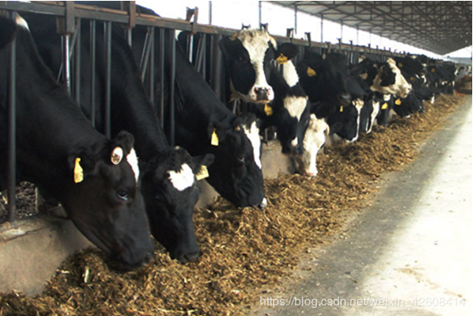

<a href="https://www.quora.com/">Quora</a>是一个海外知名的在线问答网站(类似中国的知乎、百度知道)，Quora上有许多问题和答案，也容许用户协同编辑问题和答案.不过由于某些“你懂的”原因，在国内无法访问访问该网站。在2018年9月，据Quora报告称每个月有超过3亿人访问Quora，很多人都会问重复的问题，还有很多问题具有相同意图仅仅只是表达方式不一样。 例如，“如何进行网上购物?”和“网上购物的步骤有哪些?”类似这样的问题都是重复的问题，因为它们都有相同的意图，所以应该只回答一次就可以了。

Quora正非常努力地消除重复的问题，但是这非常困难，因为对于相同的意图,不同的人可能会有不同的表达方式。如何从不同的表达方式中识别出相同的意图这是一个非常具有挑战性的工作。今天我们就来对相似问题进行研究，并通过特征工程来丰富我们的词向量表达，丰富的词向量表达方式可以帮助我们提高模型的预测准确率多人不知道什么是特征工程，为什么要搞特征工程？  

在这里我就举一个形象一点的例子来帮助大家里面特征工程的重要性：大家都知道奶牛会产奶,不同的奶牛产的牛奶质量也不完全一样，有的口感好,质量高，有的口感差，质量也就差一点，那么牛奶质量的好坏取决于什么呢？牛奶质量主要取决于奶牛所吃的饲料,奶牛的饲料大致可分为粗饲料和精饲料两种，如果你只给奶牛喂粗饲料,那么奶牛所产的牛奶的质量可能就要差一点，但是如果你给奶牛喂粗饲料的时候同时配上精饲料，那么它产的奶的质量就要比只吃粗饲料的奶牛产的奶的质量要高。在这里我们可以把奶牛比作我们的算法模型,牛奶的质量比作模型的质量(预测准确率等指标),饲料就好比是我们的训练数据集(特征集)。奶牛吃饲料并产奶的过程就好比我们把训练数据喂给算法模型,模型就产生了预测的能力。此时模型预测能力的好坏就取决于我们所喂的训练数据(特征集),如果你只给模型喂当前的特征集,这就好比你只给奶牛喂粗饲料，那么模型的质量和牛奶的质量都不会高。因此我们要在当前特征集(粗饲料)的情况下，研发出更有价值的新的特征集(精饲料)，这个过程我们就称之为特征工程，只有当我们的模型同时吃了“粗饲料”和“精饲料”，它产出“奶”的质量才会更好。我举的这个奶牛的例子不一定科学,但它能比较形象的帮助大家来理解什么是特征工程。

今天我们处理文本的特征工程会用到以下一些方法:
* basic 
* BOW（词袋）
* tf-idf
* svd
* fuzzywuzzy
* distance 
* word2vec  
虽然我们这次处理的是英文的文本,但是相信通过对上述方法的学习,对我们日后处理中文文本也会有很好的借鉴作用。

# 数据

我们的数据来自于Kaggle，你可以在此<a href="https://www.kaggle.com/c/quora-question-pairs/data">下载</a>,在train表中有3个主要字段:

* question1和question2:对问题的完整描述
* is_duplicate  - 目标变量，如果question1和question2具有基本相同的含义，则为1，否则为0。

In [46]:
import pandas as pd
import numpy as np
import gensim
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import gensim
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import scipy
from tqdm import tqdm_notebook

In [35]:
df = pd.read_csv('./data/quora/train.csv')
df = df.dropna(how="any").reset_index(drop=True)
print(len(df))
df.sample(5)

404287


,id,qid1,qid2,question1,question2,is_duplicate
188944,188945,287596,287597,"What is it like to take the course ""Bio 183 : ...",Why should I take bio in class 11th?,0
337839,337841,465346,465347,What do Western people think about Chinese?,How do Westerners think about Chinese people?,1
94856,94856,158315,158316,I have done my graduation in architecture from...,Did Marx believe workers and their employers e...,0
186347,186348,100902,101614,Is it unhealthy to swallow one's own phlegm du...,Why does the top of my throat hurt when I swal...,0
257599,257601,372956,372957,What is the risk of intercaste marriage and ho...,What is the matter between me and my boyfriend...,0


总共有40多万条记录，下面我们看一下目标变量的分布情况:

is_duplicate
0    255024
1    149263
Name: id, dtype: int64


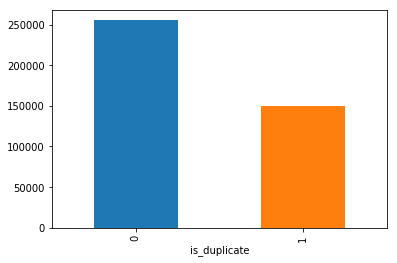

In [36]:
print(df.groupby("is_duplicate")['id'].count())
df.groupby("is_duplicate")['id'].count().plot.bar()

看来大部分的问题都被标记为0，少部分被标记为1,下面我们随机抽取10条记录的question1和question2看看:

In [4]:
for i in df.sample(10).index:
    print(df.question1[i])
    print(df.question2[i])
    print()

How do I play cards by myself?
How do I play cards?

What is the power of positive thinking?
How do you cultivate the power of positive thinking?

Why does Brick whisper to his chest every time he lies or hears an interesting word (The Middle)?
Lies and Lying: What is the easiest way to catch a liar?

How do I Study Limits in Mathematics in Simplest Way?
Why does the English level of Hong Kong lag behind Nordic countries?

After being a Java developer for 8 years what is the scope in Cloud?
Is it possible to become a Java Developer within 1 year? And after learning Java I wanna earn $500+/month from my home.

Aggressive investing in MF. Do not know basics of MF like purchasing, selling, closing funds. I know concept and returns of MF?
I'm an 20 y/o, want to invest in MF by SIP 2k per month. Will I have to file an income tax return for it at the end of FY?

What was the awesomest dream you had?
What's the saddest dream you've ever had?

What are the characteristics of the Medieval perio

 接下来我们删除不需要的字段：

In [5]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

# 特征工程
## basic
基本特征工程包括计算question1和question2的长度,以及它们的长度差，计算每个question的字符数等，主要包含以下功能:

* 计算question1的长度
* 计算question2的长度
* 计算question1和question2的长度差
* 计算过滤掉空格后的question1的字符长度
* 计算过滤掉空格后的question2的字符长度
* 计算question1中的单词数量
* 计算question2中的单词数量
* 计算question1和question2中的常用单词数量

In [6]:
# 计算question1和question2的长度
df['len_q1'] = df.question1.apply(lambda x: len(str(x)))
df['len_q2'] = df.question2.apply(lambda x: len(str(x)))

# 计算两个问题的长度差
df['diff_len'] = df.len_q1 - df.len_q2

# 计算两个问题的字符数量
df['len_char_q1'] = df.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df['len_char_q2'] = df.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))

# 计算两个问题的单词数
df['len_word_q1'] = df.question1.apply(lambda x: len(str(x).split()))
df['len_word_q2'] = df.question2.apply(lambda x: len(str(x).split()))

# 计算两个问题的常用单词数
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2'])
                                                                                                          .lower().split()))), axis=1)
df

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,10
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,4
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10,4
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,-15,19,26,11,9,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,37,25,18,13,7,2
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,86,90,-4,26,27,16,16,8
6,Should I buy tiago?,What keeps childern active and far from phone ...,0,19,62,-43,14,20,4,11,0
7,How can I be a good geologist?,What should I do to be a great geologist?,1,30,41,-11,16,16,7,9,4
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37,-6,16,16,8,8,6
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,60,49,11,25,24,9,9,3


为了以后使用方便,我们将基本特征集记录为fs_basic:

In [7]:
fs_basic = df[['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 
        'len_char_q2', 'len_word_q1', 'len_word_q2',     
        'common_words']]

## BOW(词袋)
关于BOW在我之前的多篇博客中均有使用及说明,这里不再详细阐述其原理，我们在这里使用的词袋模型为sklearn的CountVectorizer,为了以后使用方便,我们将bow特征集记录为fs_bow:

In [8]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = count_vect.transform(df['question1'].values)
trainq2_trans = count_vect.transform(df['question2'].values)
fs_bow = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
fs_bow.shape

(404287, 172708)

In [25]:
print(fs_bow)

  (0, 14288)	1
  (0, 34376)	1
  (0, 38705)	2
  (0, 38976)	1
  (0, 40287)	1
  (0, 40598)	1
  (0, 47859)	1
  (0, 69203)	1
  (0, 72848)	2
  (0, 76405)	1
  (0, 77236)	1
  (0, 83272)	1
  (1, 23441)	1
  (1, 37728)	1
  (1, 40598)	1
  (1, 43564)	1
  (1, 43567)	1
  (1, 53740)	1
  (1, 54691)	1
  (1, 73117)	1
  (1, 76405)	1
  (1, 83272)	1
  (2, 4061)	1
  (2, 14752)	1
  (2, 19067)	1
  :	:
  (404285, 124082)	3
  (404285, 132098)	1
  (404285, 141045)	1
  (404285, 141392)	1
  (404285, 142166)	1
  (404285, 146851)	1
  (404285, 147333)	1
  (404285, 147406)	1
  (404285, 156048)	1
  (404285, 159838)	1
  (404285, 163590)	1
  (404285, 166960)	1
  (404285, 168942)	1
  (404285, 169187)	1
  (404285, 169713)	1
  (404286, 106449)	1
  (404286, 121781)	1
  (404286, 126952)	1
  (404286, 127166)	1
  (404286, 131808)	1
  (404286, 155320)	1
  (404286, 163590)	1
  (404286, 169626)	1
  (404286, 170185)	1
  (404286, 171405)	1


我们最后得到的词袋特征集fs_bow是一个稀疏矩阵，因为稀疏矩阵中存在大量的零元素，因次我们使用了scipy.sparse来存储稀疏矩阵(只存储非零元素)。  
CountVectorizer模型所用的参数请参考我之前的几篇博客或者官方<a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">文档</a>，这里不再详细阐述。

## TF-IDF
关于TF-IDF在我之前的多篇博客中均有使用及说明,这里不再详细阐述其原理，我们在这里使用的tf-idf模型为sklearn的TfidfVectorizer,在这里我们所使用的tf-idf也可以分为两种类型:

* 基于word的tf-idf
* 基于字符的tf-idf

## 基于word的TF-IDF

In [27]:
tfidf_vect = TfidfVectorizer(analyzer='word',min_df=3,token_pattern=r'\w{1,}',ngram_range=(1,2),max_features=5000)
tfidf_vect.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = tfidf_vect.transform(df['question1'].values)
trainq2_trans = tfidf_vect.transform(df['question2'].values)
fs_tfidf_word = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

In [28]:
print(fs_tfidf_word.shape)
print(fs_tfidf_word)

(404287, 10000)
  (0, 4701)	0.10705452704845354
  (0, 4686)	0.07102608407800481
  (0, 4365)	0.28380318790374565
  (0, 4325)	0.09053474417047624
  (0, 4070)	0.07199046915353155
  (0, 3885)	0.6044443034571639
  (0, 3688)	0.26848538329582405
  (0, 2666)	0.24540151135699356
  (0, 2332)	0.11319372125290773
  (0, 2302)	0.07748232804955184
  (0, 2284)	0.28741457540684634
  (0, 2283)	0.26132380639065944
  (0, 2220)	0.16100996840725149
  (0, 2167)	0.1804985788305284
  (0, 2131)	0.17919206608579683
  (0, 1786)	0.31644539595632626
  (0, 718)	0.17733289630469834
  (1, 4701)	0.22431033613032303
  (1, 4686)	0.1488202809615606
  (1, 4205)	0.6674187992832605
  (1, 4070)	0.15084094787228883
  (1, 3901)	0.5443290021220754
  (1, 2969)	0.2047615733016986
  (1, 2332)	0.2371737315750311
  (1, 2302)	0.16234798777905576
  :	:
  (404285, 6971)	0.17209701242505268
  (404285, 6968)	0.2511182909643519
  (404285, 6857)	0.2112292700042006
  (404285, 6805)	0.21463625418243842
  (404285, 5707)	0.2226452925862841
  (4

### 基于字符的TF-IDF

In [10]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',min_df=3, token_pattern=r'\w{1,}',ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram_chars.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = tfidf_vect_ngram_chars.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram_chars.transform(df['question2'].values)
fs_tfidf_char = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

In [29]:
print(fs_tfidf_char.shape)
print(fs_tfidf_char)

(404287, 8466)
  (0, 3281)	0.059408417777667824
  (0, 3280)	0.04691817403787812
  (0, 3194)	0.04661816411292095
  (0, 3163)	0.034010039166989955
  (0, 3138)	0.07510349065656595
  (0, 3105)	0.06246931824583835
  (0, 3083)	0.13696525746098426
  (0, 3053)	0.04318358930378903
  (0, 3030)	0.06648582962546076
  (0, 3023)	0.04872696838733591
  (0, 3020)	0.13313229764041307
  (0, 2980)	0.1260106149342917
  (0, 2979)	0.22730658293683764
  (0, 2961)	0.18604661449054205
  (0, 2949)	0.09538016471912954
  (0, 2908)	0.03944565529120923
  (0, 2907)	0.16315589220320564
  (0, 2882)	0.1257604073162725
  (0, 2876)	0.05246349559627378
  (0, 2835)	0.06760911796842292
  (0, 2734)	0.22273472062657
  (0, 2733)	0.09583233445589848
  (0, 2675)	0.05684459251804122
  (0, 2674)	0.03207201045344375
  (0, 2659)	0.1542406217249039
  :	:
  (404286, 6573)	0.08170765471321281
  (404286, 6568)	0.0693186600518891
  (404286, 6565)	0.18302328550227354
  (404286, 6525)	0.2317370681786679
  (404286, 6491)	0.1458068403845505
 

TF-IDF模型所用的参数请参考我之前的几篇博客或者官方<a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html">文档</a>，这里不再详细阐述。

### SVD

In [11]:
svd_word = TruncatedSVD(n_components=180)
fs_svd_word = svd_word.fit_transform(fs_tfidf_word)

svd_char = TruncatedSVD(n_components=180)
fs_svd_char = svd_word.fit_transform(fs_tfidf_char)


In [23]:
fs_svd_char

array([[ 0.98267634, -0.23215909,  0.02747437, ...,  0.04489017,
        -0.05978618,  0.02866485],
       [ 0.68478225,  0.05307884,  0.02009335, ..., -0.02889406,
        -0.0165864 ,  0.02442127],
       [ 0.99499667,  0.03737898, -0.24064723, ..., -0.03016285,
        -0.02605614, -0.01316587],
       ...,
       [ 0.67501132, -0.12496264, -0.06988968, ...,  0.08736301,
        -0.09284343,  0.01386804],
       [ 1.03160088,  0.03845416, -0.16618059, ..., -0.032724  ,
        -0.01081504, -0.02411288],
       [ 0.92788675, -0.03182808,  0.21893472, ...,  0.06029335,
        -0.03187918, -0.014335  ]])

In [24]:
fs_svd_word

array([[ 0.25149603, -0.11164787, -0.10708006, ..., -0.03803665,
         0.04232418,  0.02085518],
       [ 0.32606597, -0.08005594, -0.11615087, ..., -0.01711403,
         0.019761  ,  0.03849519],
       [ 0.17020132,  0.22485091, -0.00103089, ...,  0.02158829,
        -0.00299343, -0.00580703],
       ...,
       [ 0.24639001, -0.1427365 , -0.1458868 , ..., -0.05916298,
        -0.03890851,  0.00746957],
       [ 0.24953584,  0.02531907, -0.05678903, ...,  0.04379823,
        -0.09676218, -0.05425369],
       [ 0.25625918, -0.07755943, -0.16841648, ...,  0.00701458,
         0.0874248 , -0.01578459]])

经过SVD降维后，tf-idf特征集的维度降到了180维。

## fuzzywuzzy
<a href="https://github.com/seatgeek/fuzzywuzzy">fuzzywuzzy</a>是python的一个用来进行模糊字符串匹配的工具,它的基本原理是基于计算两个相似字符串之间的编辑距离，fuzzywuzzy提供了多种比率(ratio)来描述两个字符串之间的相似程度。主要包含以下几种比率:

* QRatio
* WRatio
* Partial ratio
* Partial token set ratio
* Partial token sort ratio
* Token set ratio
* Token sort ratio  
我们看看下面几个例子:

In [13]:
fuzz.QRatio("How can I start an online shopping (e-commerce) website?",
            "Which web technology is best suitable for building a big E-Commerce website?")

54

In [14]:
fuzz.partial_ratio("Why did Trump win the Presidency?", 
                   "How did Donald Trump win the 2016 Presidential Election")

73

In [15]:
fuzz.partial_ratio("How can I start an online shopping (e-commerce) website?", 
                   "Which web technology is best suitable for building a big E-Commerce website?")

55

In [16]:
fuzz.token_set_ratio("今天 天气 非常好","今天 天气 很好")

82

根据fuzzywuzzy返回的ratio值越高，说明两个字符串越相似。下面就让我们在原始数据上计算一下fuzzywuzzy的各自ritio:

In [18]:
df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['question1']),str(x['question2'])), axis=1)
df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['question1']),str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']),str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x:fuzz.partial_token_set_ratio(str(x['question1']),str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x:fuzz.partial_token_sort_ratio(str(x['question1']),str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x:fuzz.token_set_ratio(str(x['question1']),str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']),str(x['question2'])), axis=1)

为了便于以后的使用,我们将fuzzywuzzy的特征集记为fs_fuzz:

In [22]:
fs_fuzz = df[['fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio', 
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']]
fs_fuzz

,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,93,95,98,100,88,100,93
1,66,86,73,100,73,86,63
2,43,60,41,100,71,63,63
3,9,27,20,32,30,28,24
4,35,86,54,100,67,67,47
5,72,74,67,100,71,78,74
6,20,35,32,39,39,24,23
7,61,67,67,100,69,71,61
8,86,88,90,100,93,93,87
9,49,62,57,100,55,65,44


## Distance
接下来我们将另外一个距离特征集,我们将计算question1和question2之间的各种空间距离,主要包括:

* 余弦距离(Cosine distance) 
* 曼哈顿距离（Manhattan distance）
* Jaccard 距离
* 堪培拉距离(Canberra distance)
* 欧式距离( Euclidean distance)
* 闵可夫斯基的距离（Minkowski distance）
* 布雷柯蒂斯距离(Bray-Curtis distance)


在计算距离之前我们要先将question1和question2中的问题句子进行向量化处理,因此我们要定义一个将句子向量化的函数,然后再将question1和question2进行向量化:

In [47]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

#创建question1的句向量
question1_vectors = np.zeros((df.shape[0], 300))
for i, q in enumerate(tqdm_notebook(df.question1.values)):
    question1_vectors[i, :] = sent2vec(q)
    
#创建question2的句向量    
question2_vectors  = np.zeros((df.shape[0], 300))
for i, q in enumerate(tqdm_notebook(df.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


完成了question1和question2的向量化以后,我们就可以开始计算question1和question2之间的空间距离了:

In [48]:
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]

d:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:853: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.double(unequal_nonzero.sum()) / np.double(nonzero.sum())
d:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:1138: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


为了便于以后的使用,我们将距离的特征集记为fs_distance :

In [49]:
fs_distance = df[['cosine_distance','cityblock_distance','jaccard_distance',
                'canberra_distance','euclidean_distance','minkowski_distance','braycurtis_distance']]
fs_distance

,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557
1,0.512164,14.195119,1.0,177.588090,1.012091,0.455910,0.592655
2,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306
3,0.650411,15.987437,1.0,192.237828,1.140536,0.506028,0.692421
4,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633
5,0.275242,10.254048,1.0,150.335589,0.741946,0.337470,0.400061
6,0.820637,17.414754,1.0,200.598725,1.281122,0.597082,0.816676
7,0.064615,5.008762,1.0,95.395891,0.359486,0.161125,0.187150
8,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
9,0.284710,10.634987,1.0,153.647611,0.754599,0.337939,0.409126


## word2vec
一般来说，Word2vec模型是两层神经网络，它将文本语料库作为输入并输出该语料库中每个单词的向量。经拟合后，具有相似含义的词的向量彼此接近，也就是说，词义相近的单词之间的距离要比那些词义不同的词之间的距离要小。

如今，Word2vec已成为自然语言处理问题的标准，并且通常它为信息检索任务提供了非常有用的帮助。我们将使用Google新闻媒介。这是在Google新闻语料库中的预训练Word2vec模型。你可以在这里下载这个预训练的语料库(https://pan.baidu.com/s/1UNE1W60JUN6HuaRMvwNMHg 提取码：ya5b )。 如果你使用来自Google新闻语料库的预训练向量，则其中的所有单词（如“德国”，“柏林”，“法国”和“巴黎”）都可以用300维向量表示。当我们对这些单词使用Word2vec表示时，我们从“柏林”的向量中减去“德国”的向量再加上“法国”的向量，我们将得到一个与“巴黎”的向量非常相似的向量,即:

V("柏林") - V(“德国”) + V("法国") ≈ V("巴黎")

如过想对Word2vec进一步了解，阅读<a href="https://www.distilled.net/word2vec-examples/">这个</a>和<a href="http://www.1-4-5.net/~dmm/ml/how_does_word2vec_work.pdf">这个</a>  
因此，Word2vec模型承载了向量中单词的含义。这些载体所携带的信息对我们的任务构成了非常有用的特征。要加载Word2vec向量，我们要使用Gensim：

In [31]:
import gensim
from gensim.models import Word2Vec
    
wmd_model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_wmd_model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

## WMD（Word Mover's Distance）
<a href="http://proceedings.mlr.press/v37/kusnerb15.pdf">WMD</a>是一种评估两个文档之间的“距离”的方法，它可以用于检索内容相似的问题,比如对应某些博客的推荐系统中,可以给用户推荐与用户当前所看的博客内容相似的其他博客,这时就用的WMD技术。如果你想进一步了解如何使用WMD，那么可以阅读这个文档。下面我们先定义一个测量文档之间距离的函数:

In [50]:
def wmd(q1, q2, model, norm=False):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    stop_words = stopwords.words('english')
    q1 = [w for w in q1 if w not in stop_words]
    q2 = [w for w in q2 if w not in stop_words]
    if norm == True:
        model.init_sims(replace=True)
    return model.wmdistance(q1, q2)

参数norm表示是否需要对word2vec向量进行标准化处理(归一化)。那么我们将对question1和question2的word2vec向量进行两种方式处理即,不使用归一化和使用归一化。最后为了便于以后使用，我们将WMD的特征集记为fs_wmd:

In [ ]:
df['wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2'],wmd_model), axis=1)
df['norm_wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2'],norm_wmd_model,norm=True), axis=1)
fs_wmd=df[['wmd','norm_wmd']]
fs_wmd

# 总结
到目前为止我们已经为我们的“奶牛”准备了以下几种“饲料”:


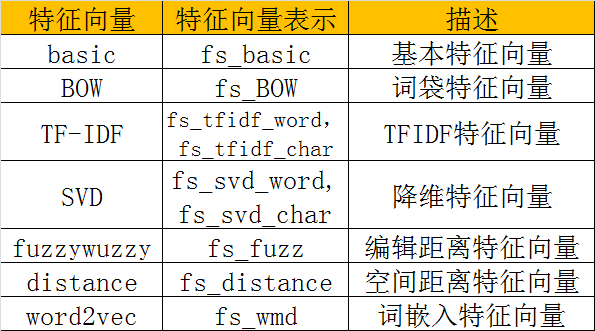


总共有7种类的特征向量,9个特征向量集。接下来我们要将这些特征向量集进行各种组合，然后将他们“喂”给我们的算法模型(XGBoost或者逻辑回归)，并评估我们的模型在“吃”了这些“饲料”后的表现会如何?